In [18]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle

import torch
from torch.nn import CrossEntropyLoss, NLLLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from os.path import exists

from util import test_loss, train_NN, inference_time, loadCIFAR10, plot_loss, plot_acc, plot_shifts

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 100
input_shape = (batch_size, 3, 32, 32)
num_labels = 10

train_dataset, train_dataloader, test_dataset, test_dataloader, classes = loadCIFAR10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


## VGG

In [7]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/VGG/VGG_optimizer.pkl', 'rb') as file:
    VGG_optim = pickle.load(file)

best_parameters = VGG_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[0]

[{'acc': 74.252, 'lr': 0.09375, 'momentum': 0.65625, 'p_randomTransform': 0.3125}, {'acc': 72.152, 'lr': 0.08378864744949828, 'momentum': 0.7315053974289858, 'p_randomTransform': 0.7782211507973548}, {'acc': 71.808, 'lr': 0.018873064116434416, 'momentum': 0.9292819279334161, 'p_randomTransform': 0.7836328125}]


In [8]:
from Models import VGGNet

VGGNN = VGGNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0, p_drop=0.2)

summary(VGGNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 32, 32]         896
│    └─ReLU: 2-2                         [100, 32, 32, 32]         --
│    └─Conv2d: 2-3                       [100, 32, 32, 32]         9,248
│    └─ReLU: 2-4                         [100, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [100, 32, 16, 16]         --
│    └─Dropout2d: 2-6                    [100, 32, 16, 16]         --
│    └─Conv2d: 2-7                       [100, 64, 16, 16]         18,496
│    └─ReLU: 2-8                         [100, 64, 16, 16]         --
│    └─Conv2d: 2-9                       [100, 64, 16, 16]         36,928
│    └─ReLU: 2-10                        [100, 64, 16, 16]         --
│    └─MaxPool2d: 2-11                   [100, 64, 8, 8]           --
│  

In [9]:
PATH = "models/VGG/VGGNet.pth"

if exists(PATH):
    VGGNN = torch.load(PATH)
    VGGNN.eval()

In [10]:
criterion = CrossEntropyLoss()
epochs = 30

train_NN(VGGNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2, device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 2.303
test_loss: 2.304, test_accuracy: 10.0
[1,   200] train_loss: 2.303
test_loss: 2.296, test_accuracy: 12.11
[1,   300] train_loss: 2.160
test_loss: 2.003, test_accuracy: 27.96
[1,   400] train_loss: 1.952
test_loss: 1.851, test_accuracy: 31.26
[1,   500] train_loss: 1.838
test_loss: 1.698, test_accuracy: 38.71
[2,   100] train_loss: 1.715
test_loss: 1.595, test_accuracy: 40.7
[2,   200] train_loss: 1.647
test_loss: 1.507, test_accuracy: 44.67
[2,   300] train_loss: 1.591
test_loss: 1.425, test_accuracy: 47.76
[2,   400] train_loss: 1.535
test_loss: 1.399, test_accuracy: 48.73
[2,   500] train_loss: 1.496
test_loss: 1.486, test_accuracy: 47.38
[3,   100] train_loss: 1.427
test_loss: 1.277, test_accuracy: 53.67
[3,   200] train_loss: 1.382
test_loss: 1.251, test_accuracy: 54.75
[3,   300] train_loss: 1.314
test_loss: 1.166, test_accuracy: 57.86
[3,   400] train_loss: 1.286
test_loss: 1.139, test_accuracy: 58.84
[3,   500] train_loss: 1.296
test_loss: 1.090, tes

In [11]:
torch.save(VGGNN, "./models/VGG/VGGNet.pth")

In [12]:
VGGNN = torch.load("./models/VGG/VGGNet.pth")

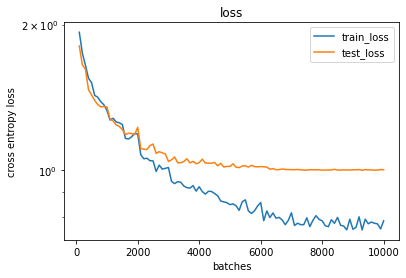

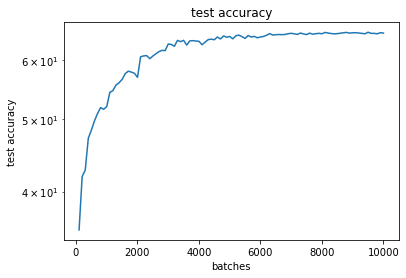

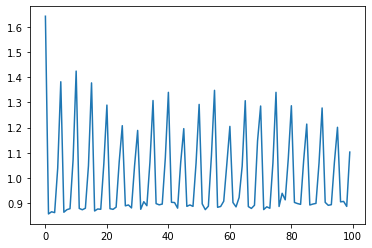

1.00747308645


In [14]:
plot_loss(VGGNN)
plot_acc(VGGNN)

plt.plot(VGGNN.train_time)
plt.show()
print(np.mean(VGGNN.train_time))

## ASL VGG

In [8]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/VGG/ASL_VGG_optimizer.pkl', 'rb') as file:
    ASL_VGG_optim = pickle.load(file)

best_parameters = ASL_VGG_optim.get_best_parameters(3)
print(best_parameters)
parameters = best_parameters[1]

[{'acc': 82.592, 'lr': 0.05224609375, 'momentum': 0.78564453125, 'p_randomTransform': 0.0107421875}, {'acc': 79.078, 'lr': 0.08947506874612457, 'momentum': 0.5519628906250001, 'p_randomTransform': 0.6442425579588916}, {'acc': 78.9, 'lr': 0.10085937499999999, 'momentum': 0.6542951899242178, 'p_randomTransform': 0.5951562499999999}]


In [9]:
from Models import ASL_VGGNet

ASL_VGGNN = ASL_VGGNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0, device=device, p_drop=0.2, expansion_rate=1)

summary(ASL_VGGNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ASL_VGGNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 32, 32]         896
│    └─ReLU: 2-2                         [100, 32, 32, 32]         --
│    └─CSC_block: 2-3                    [100, 32, 32, 32]         --
│    │    └─Sequential: 3-1              --                        2,240
│    │    └─Identity: 3-2                [100, 32, 32, 32]         --
│    └─ReLU: 2-4                         [100, 32, 32, 32]         --
│    └─MaxPool2d: 2-5                    [100, 32, 16, 16]         --
│    └─Dropout2d: 2-6                    [100, 32, 16, 16]         --
│    └─CSC_block: 2-7                    [100, 64, 16, 16]         --
│    │    └─Sequential: 3-3              --                        2,240
│    │    └─Conv2d: 3-4                  [100, 64, 16, 16]         2,112
│    

In [10]:
PATH = "models/VGG/ASL_VGGNet.pth"

if exists(PATH):
    ASL_VGGNN = torch.load(PATH)
    ASL_VGGNN.eval()

In [11]:
criterion = CrossEntropyLoss()
epochs = 30

train_NN(ASL_VGGNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2, device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 2.024
test_loss: 1.782, test_accuracy: 34.12
[1,   200] train_loss: 1.793
test_loss: 1.586, test_accuracy: 40.63
[1,   300] train_loss: 1.694
test_loss: 1.560, test_accuracy: 42.82
[1,   400] train_loss: 1.619
test_loss: 1.537, test_accuracy: 42.81
[1,   500] train_loss: 1.557
test_loss: 1.432, test_accuracy: 47.94
[2,   100] train_loss: 1.505
test_loss: 1.437, test_accuracy: 48.31
[2,   200] train_loss: 1.467
test_loss: 1.295, test_accuracy: 53.04
[2,   300] train_loss: 1.431
test_loss: 1.273, test_accuracy: 54.03
[2,   400] train_loss: 1.417
test_loss: 1.264, test_accuracy: 54.58
[2,   500] train_loss: 1.376
test_loss: 1.199, test_accuracy: 56.04
[3,   100] train_loss: 1.341
test_loss: 1.164, test_accuracy: 58.39
[3,   200] train_loss: 1.316
test_loss: 1.197, test_accuracy: 57.82
[3,   300] train_loss: 1.303
test_loss: 1.131, test_accuracy: 59.34
[3,   400] train_loss: 1.250
test_loss: 1.086, test_accuracy: 61.32
[3,   500] train_loss: 1.221
test_loss: 1.051, t

In [12]:
torch.save(ASL_VGGNN, "./models/VGG/ASL_VGGNet.pth")

In [14]:
ASL_VGGNN = torch.load("./models/VGG/ASL_VGGNet.pth")

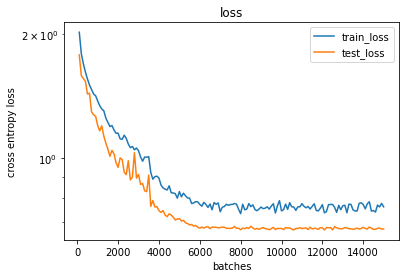

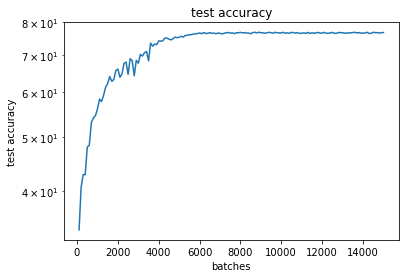

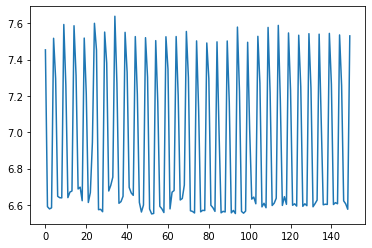

6.924280731806667


In [15]:
plot_loss(ASL_VGGNN)
plot_acc(ASL_VGGNN)

plt.plot(ASL_VGGNN.train_time)
plt.show()
print(np.mean(ASL_VGGNN.train_time))

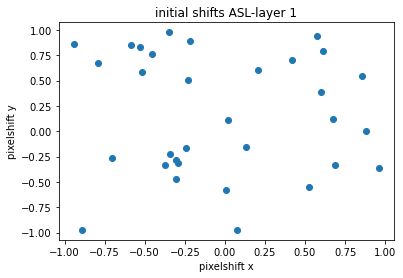

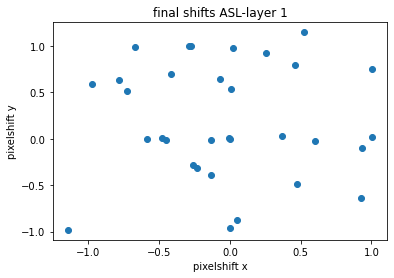

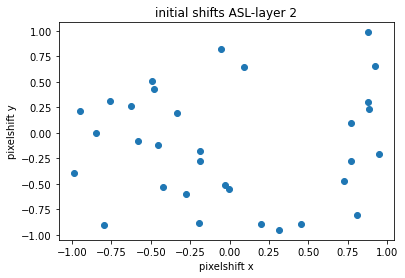

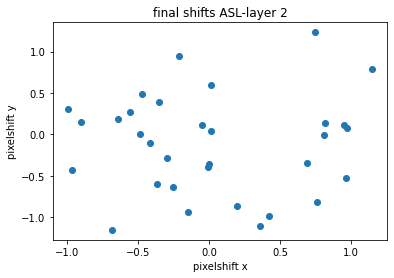

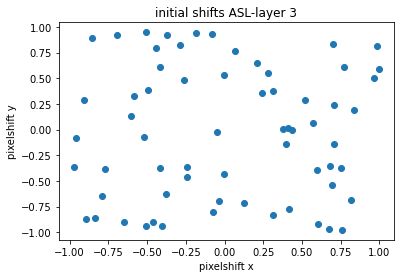

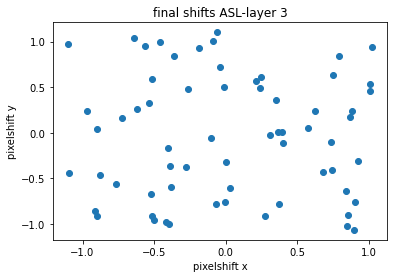

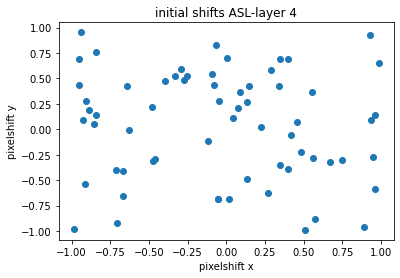

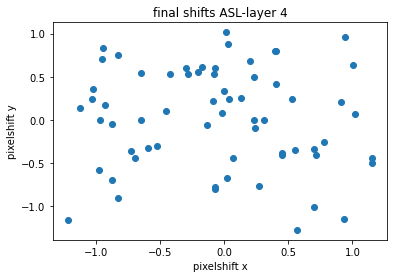

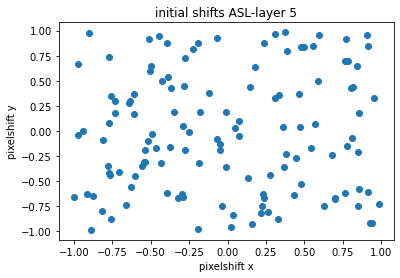

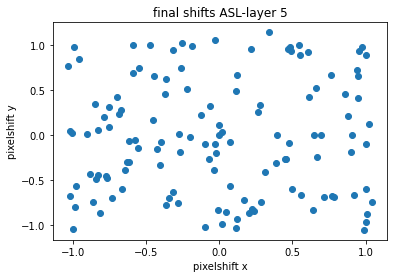

In [19]:
plot_shifts(ASL_VGGNN)